## Description
Author: shuheng.mo21@imperial.ac.uk (sm321@ic.ac.uk)          

This notebook contains the parallelisation of 2D Advection-diffusion equation implemented with MPI (mpi4py). The script within this notebook is converted to Python scripts and presented at [here](https://github.com/ese-msc-2021/irp-sm321/tree/main/code).          


## Prerequisites

Datatypes map between mpi4py and the numpy:(reference: https://groups.google.com/g/mpi4py/c/u33WWWKThDs)        
```
typemap = {
        np.dtype(np.float64) : MPI.DOUBLE,
        np.dtype(np.float32) : MPI.FLOAT,
        np.dtype(np.int)     : MPI.INT,
        np.dtype(np.int8)    : MPI.CHAR,
        np.dtype(np.uint8)   : MPI.UNSIGNED_CHAR,
        np.dtype(np.int32)   : MPI.INT,
        np.dtype(np.uint32)  : MPI.UNSIGNED_INT,
    }
```

Note: we can pass numpy datatypes into Tensorflow tensor.  
Please remember to install the required dependencies below.

In [1]:
## Install the required dependencies
# ! python -m pip install mpi4py
! mkdir serial_steps
! mkdir parallel_steps
! mkdir serial_out
! mkdir parallel_out
! rm -r serial_steps/*
! rm -r parallel_steps/*
! rm -r serial_out/*
! rm -r parallel_out/*

mkdir: serial_steps: File exists
mkdir: parallel_steps: File exists
mkdir: serial_out: File exists
mkdir: parallel_out: File exists


## Problem Details
Boyang et al. have implemented the [CFD model](https://www.imperial.ac.uk/people/c.heaney/document/9723/AI_for_CFD_v1b/?AI_for_CFD_v1b.pdf) for solving 2D advection-diffusion equation with TensorFlow. This notebook cited their implementation and was legally approved. The problem was formulated as below:                

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y}+ \sigma T- \nu \nabla^2T = s $.               

in which T is a scalar concentration field with size 300m by 300m,$t$ is time, ($u,v$) are the advection velocities.$\sigma$,$\nu$ and $s$ respectively are the absorption term, constant diffusivity and source term. Boundary conditions fixed zero solutions at the edges of the domain (No-flux boundary condition). Note for the equation formulated in this work, $\sigma = s = 0$ and advection velocity is fixed with ($1ms^{-1},1ms^{-1}$). So the expected pattern for those two initialised distributions are to be advected to the upper-right corner while diffused with constant coefficient.

alternatively the problem can be formulated as:

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y} = \nu \nabla^2T $. 


## Serial Code

In [2]:
%%writefile advection_diffusion_2D.py
## imports
import sys
import os
assert sys.version_info >= (3,5)

import math

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue


################################ Load data and initial conditions #######################
# Load data and set initial condition
nx, ny = 300, 300
T = np.zeros([nx, ny], dtype=np.float64)
gamma = 40
# initialise t:
x0 = 0
y0 = -50
x = np.zeros([1, nx], dtype=np.float64)
y = np.zeros([1, ny], dtype=np.float64)

for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii

# boundary excluded: range 1-299 x 1-299, I suppose we are using Dirichlet boundary condition
for i in range(1, 299):
    for j in range(1, 299):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)

input_shape = (1, nx, ny, 1)  # (1,300,300,1) as original problem size

mesh = np.zeros(input_shape, dtype=np.float64) # default data type of np.zeros is np.float64

# generate Gaussian with a blob
for i in range(nx):
    for j in range(ny):
        mesh[0][i][j][0] = T[i][j]  # + Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5

# generate Gaussian with a blob
for i in range(50):
    for j in range(50):
        mesh[0][i+225][j+125][0] = mesh[0][i+225][j+125][0] + 1

values = np.copy(mesh) # no copy needed actually

# values is just a copy of mesh

################################ Initializations ####################################

# weight matrices
w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])

# print(np.array(w1).shape) # shape (1,3,3,1)
init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          #                                activation='relu',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
    #         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
    #                                activation='relu',
    #                                kernel_initializer=kernel_initializer_2,
    #                                bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          #                                activation='relu',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
    #         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
    #                                activation='relu',
    #                                kernel_initializer=kernel_initializer_2,
    #                                bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
              optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

# store the l1,l2,linf norms
l1_norms = np.array([])
l2_norms = np.array([])
linf_norms = np.array([])

start_time = time.perf_counter()

# running for 1000 steps
for t in range(1000):
    
    # one-step
    # a = CNN2D_2.predict(values)
    # values += a

    # two-step scheme with central scheme
    a = CNN2D_2.predict(values)
    b = (a + values)
    c = (b + values)*0.5
    d = CNN2D_2.predict(c)
    values += d
    
    np.save('serial_steps/AD_2D_step_{}'.format(t),values)
    

    # if t %10 == 0: # save the l1 norm and l2 norm of result per 10 timesteps
    #l1_norms = np.append(l1_norms, np.linalg.norm(values.reshape(300,300), ord=1)/90000)
    #l2_norms = np.append(l2_norms, np.linalg.norm(values.reshape(300,300), ord=2)/90000)
    #linf_norms = np.append(linf_norms, np.linalg.norm(values.reshape(300,300), ord=np.inf)/90000)
    #np.save("/content/serial_steps/AD_2D_serial_step_{}".format(t),values.reshape(nx, ny))


end_time = time.perf_counter()
print(f"[INFO] Problem solved in {end_time - start_time:0.4f} seconds using serial solution.")

# save the final result to text file
np.save("serial_out/AD_2D_serial", values.reshape(nx,ny))
# np.save("/content/norms/AD_2D_serial_l1_norms", l1_norms)
# np.save("/content/norms/AD_2D_serial_l2_norms", l2_norms)
# np.save("/content/norms/AD_2D_serial_linf_norms", linf_norms)

Overwriting advection_diffusion_2D.py


In [3]:
# run the serial code
! python advection_diffusion_2D.py 

1/1 [==============================] - 0s 13ms/step
[INFO] Problem solved in 60.8391 seconds using serial solution.


## MPI subroutines
All functions for communicating halos (2D, and perhaps 3D) has been encapsulated in Python subroutine named as **halo_exchange.py**. It will be called to parallelize the corresponding code.

**Note that this subroutine is going to be improved:
```
from ... import HaloExchange
h = HaloExchange()
h.initialization()
```

## Parallelisation example

In [4]:
%%writefile parallel_advection_diffusion_2D.py
from mpi4py import MPI
# import halo_exchange
from halo_exchange_upgraded import HaloExchange
import os
import numpy as np  # cupy can be used as optimisation if CUDA/AMD GPUs are available
from tensorflow import keras
import tensorflow as tf
import math
import sys
assert sys.version_info >= (3, 5)
assert tf.__version__ >= "2.0"
np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # avoid dnn issue

################################ Load data and initial conditions #######################
# Load data and set initial condition
nx, ny = 300, 300
T = np.zeros([nx, ny], dtype=np.float64)
gamma = 40
# initialise t:
x0 = 0
y0 = -50
x = np.zeros([1, nx],dtype=np.float64)
y = np.zeros([1, ny],dtype=np.float64)

for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii

# boundary excluded: range 1-299 x 1-299, I suppose we are using Dirichlet boundary condition
for i in range(1, 299):
    for j in range(1, 299):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)

input_shape = (1, nx, ny, 1)  # (1,300,300,1) as original problem size
values = np.zeros(input_shape,dtype=np.float64) # initalization of the mesh

# generate Gaussian distribution with a blob
for i in range(nx):
    for j in range(ny):
      values[0][i][j][0] = T[i][j]  # + Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5

# generate Gaussian with a blob
for i in range(50):
    for j in range(50):
        values[0][i+225][j+125][0] = values[0][i+225][j+125][0] + 1

################################ MPI Implementation ####################################

# new strategy here
he = HaloExchange(structured=True,tensor_used=True,double_precision=True,corner_exchanged=True)
sub_nx,sub_ny,current_domain = he.initialization(values,is_periodic=False,is_reordered=False)
rank = he.rank
num_process = he.num_process

# 5 stencils
# schemes for advection-term
w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])


init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_nx+2, sub_ny+2, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_nx+2, sub_ny+2, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

# place_holder for final result
result = np.empty((1,))

# do the first update to get the halo values
current_domain = he.structured_halo_update_2D(current_domain)

start_time = MPI.Wtime() # start timer
for t in range(1000):
    # print('CURRENT_DOMAIN_SHAPE: ',current_domain.shape)
    
    # one-step method
    # a = CNN2D_2.predict(current_domain)
    # a = HaloExchange.padding_block_halo_2D(a,1,0)
    # a = tf.convert_to_tensor(a.reshape(1,sub_nx+2,sub_ny+2,1))
    # current_domain += np.copy(a)
    # current_domain = he.structured_halo_update_2D(current_domain)

    # predictor-corrector scheme
    a = CNN2D_2.predict(current_domain)
    a = HaloExchange.padding_block_halo_2D(a,1,0)
    a = a.reshape(1,sub_nx+2,sub_ny+2,1)
    b = (a + current_domain)
    c = (b + current_domain)*0.5
    c = he.structured_halo_update_2D(c) # do one halo update
    d = CNN2D_2.predict(c)
    d = HaloExchange.padding_block_halo_2D(d,1,0)
    d = d.reshape(1,sub_nx+2,sub_ny+2,1)
    current_domain += np.copy(d)
    current_domain = he.structured_halo_update_2D(current_domain)
                                 
    np.save('parallel_steps/AD_2D_proc_{}_parallel_2_step_{}'.format(rank,t),current_domain)

end_time = MPI.Wtime()

# save the sub-domain to corresponding file and then merge them together
result = current_domain.numpy().reshape(sub_nx+2, sub_ny+2) # assign the values to the placeholder
np.save("parallel_out/AD_2D_proc_{}_parallel_{}".format(rank,num_process), result[1:-1,1:-1])

####################################### Terminate the MPI communication ###################################
MPI.Finalize() # optional
print("[INFO] The problem was solved in {} ".format(end_time - start_time))

Overwriting parallel_advection_diffusion_2D.py


In [5]:
# test it on 2 subdomains as a good start
# ! mpiexec --allow-run-as-root -n 2 python parallel_advection_diffusion_2D.py
! mpiexec -n 2 python parallel_advection_diffusion_2D.py

1/1 [==============================] - 0s 15ms/step
[INFO] The problem was solved in 66.866892 
[INFO] The problem was solved in 66.866905 


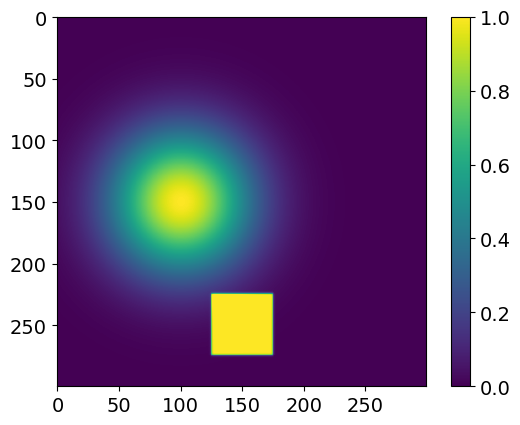

In [17]:
import numpy as np
# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

def merge_2_subdomains(part1,part2):
    return np.concatenate([part1,part2],axis=1)


serial_0 = np.load('serial_steps/AD_2D_step_0.npy').reshape(300,300)
serial_1 = np.load('serial_steps/AD_2D_step_1.npy').reshape(300,300)

plt.imshow(serial_0,vmin=0,vmax=1)
plt.colorbar()

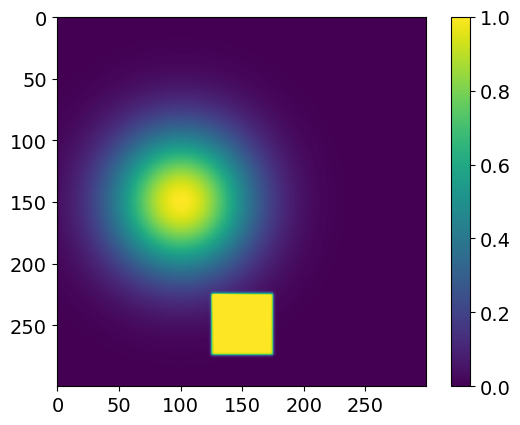

In [18]:
plt.imshow(serial_1,vmin=0,vmax=1)
plt.colorbar()

0.0

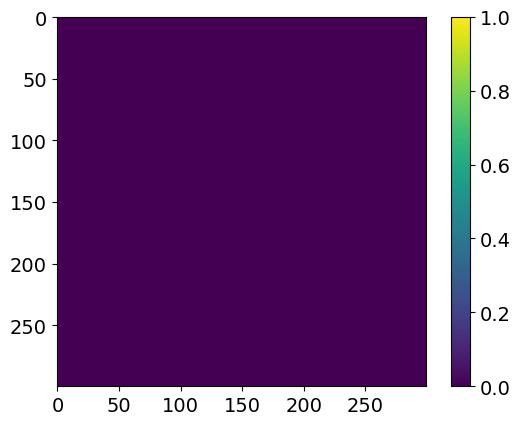

In [19]:
p_0_0 = np.load('parallel_steps/AD_2D_proc_0_parallel_2_step_0.npy').reshape(302,152)[1:-1,1:-1]
p_0_1 = np.load('parallel_steps/AD_2D_proc_1_parallel_2_step_0.npy').reshape(302,152)[1:-1,1:-1]
# p_0_0 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_0_parallel_2_step_0.npy').reshape(302,152)
# p_0_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_1_parallel_2_step_0.npy').reshape(302,152)
parallel_0 = np.concatenate([p_0_0,p_0_1],axis=1)
plt.imshow(np.abs(parallel_0 - serial_0),vmin=0,vmax=1)
# plt.imshow(parallel_0,vmin=0,vmax=1)
plt.colorbar()
np.sum(np.abs(parallel_0 - serial_0)) # completely same for 1st loop

0.0

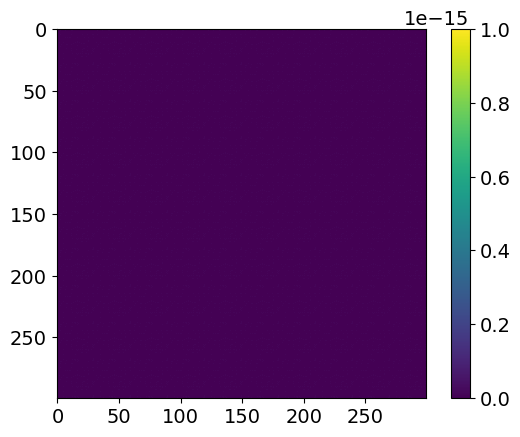

In [20]:
p_1_0 = np.load('parallel_steps/AD_2D_proc_0_parallel_2_step_1.npy').reshape(302,152)[1:-1,1:-1]
p_1_1 = np.load('parallel_steps/AD_2D_proc_1_parallel_2_step_1.npy').reshape(302,152)[1:-1,1:-1]
parallel_1 = np.concatenate([p_1_0,p_1_1],axis=1)
plt.imshow(np.abs(parallel_1 - serial_1),vmin=0,vmax=1e-15)
plt.colorbar()
np.sum(np.abs(parallel_1 - serial_1)) # this is not correct

In [21]:
## imports
import sys
assert sys.version_info >= (3,5)

import math

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import time
from mpi4py import MPI

w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])


init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(300, 300, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(300, 300, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
])

# test case
CNN2D_3 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(302, 152, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_3.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

p_0_0 = np.load('parallel_steps/AD_2D_proc_0_parallel_2_step_0.npy')
p_0_1 = np.load('parallel_steps/AD_2D_proc_1_parallel_2_step_0.npy')

serial_a_1 = CNN2D_2.predict(serial_0.reshape(1,300,300,1)).reshape(300,300)
parallel_a_1 = CNN2D_2.predict(parallel_0.reshape(1,300,300,1)).reshape(300,300)

p_test_a01 = CNN2D_3.predict(p_0_0).reshape(302,152)
p_test_a11 = CNN2D_3.predict(p_0_1).reshape(302,152)
p_test_a1 = merge_2_subdomains(p_test_a01[1:-1,1:-1],p_test_a11[1:-1,1:-1])


1/1 [==============================] - 0s 18ms/step


In [22]:
np.sum(np.abs(serial_a_1 - parallel_a_1)) # it ought to be the same

0.0

In [23]:
np.sum(np.abs(serial_a_1 - p_test_a1)) # double check the 

0.0

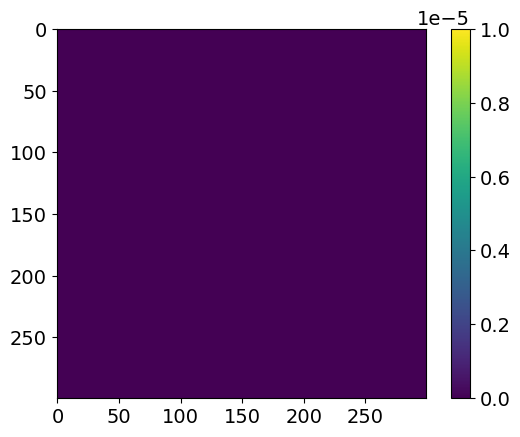

In [24]:
from pprint import pprint
plt.imshow(np.abs(serial_a_1 - p_test_a1),vmin=0,vmax=1e-5)
plt.colorbar()

(300, 300)


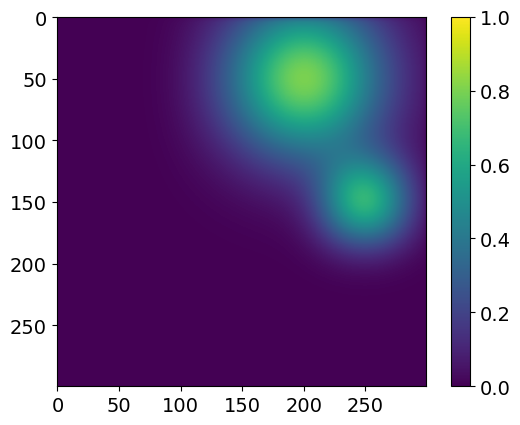

In [25]:
## Visualization and compare the final result of serial/parallel codes
import numpy as np
# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

## visualize the serial output
serial_solution = np.load("serial_out/AD_2D_serial.npy")
print(serial_solution.shape)
plt.imshow(serial_solution,vmin=0,vmax=1)
plt.colorbar()

(300, 300)


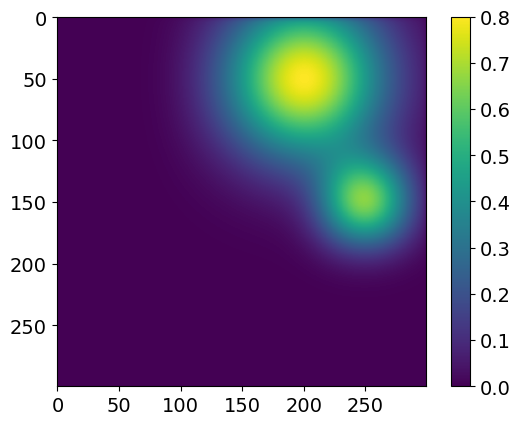

In [26]:
import numpy as np
import matplotlib.pyplot as plt

subdomains_list = []
num_process = 2
for p_id in range(0,2):
  temp = np.load("parallel_out/AD_2D_proc_{}_parallel_{}.npy".format(p_id,num_process))
  subdomains_list.append(temp)
  
# get merged result and then visualize it

# two subdomains ...
parallel_solution = np.concatenate([subdomains_list[0], subdomains_list[1]],axis = 1)
print(parallel_solution.shape)
plt.imshow(parallel_solution)
plt.colorbar()

# four subdomains ...
# parallel_solution_1 = np.concatenate([subdomains_list[0],subdomains_list[1]],axis=1) # this time we only need to combine horizontally
# parallel_solution_2 = np.concatenate([subdomains_list[2],subdomains_list[3]],axis=1) # this time we only need to combine horizontally
# parallel_solution = np.concatenate([parallel_solution_1,parallel_solution_2],axis=0)
# print(parallel_solution.shape)
# plt.imshow(parallel_solution)
# plt.colorbar()

# nine domains 
# parallel_solution_1 = np.concatenate([subdomains_list[0],subdomains_list[1],subdomains_list[2]],axis=1) # this time we only need to combine horizontally
# parallel_solution_2 = np.concatenate([subdomains_list[3],subdomains_list[4],subdomains_list[5]],axis=1) # this time we only need to combine horizontally
# parallel_solution_3 = np.concatenate([subdomains_list[6],subdomains_list[7],subdomains_list[8]],axis=1) # this time we only need to combine horizontally
# parallel_solution = np.concatenate([parallel_solution_1,parallel_solution_2,parallel_solution_3],axis=0)
# print(parallel_solution.shape)
# plt.imshow(parallel_solution)
# plt.colorbar()

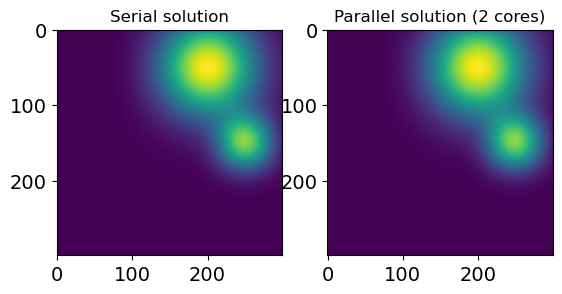

abe: 0.0
avg abe: 0.0
norm abe: 0.0
avg norm abe: 0.0


In [27]:
# compare the visualization 
fig, axes = plt.subplots(1, 2)
axes[0].imshow(serial_solution)
axes[0].title.set_text('Serial solution')
axes[1].imshow(parallel_solution)
axes[1].title.set_text('Parallel solution (2 cores)')

plt.savefig("result_validation.png")
plt.show()
# all error should be zero
print('abe:',np.sum(np.abs(serial_solution - parallel_solution)))
print('avg abe:',np.sum(np.abs(serial_solution - parallel_solution))/(300*300))
print('norm abe:',np.abs(np.linalg.norm(serial_solution) - np.linalg.norm(parallel_solution)))
print('avg norm abe:',np.abs(np.linalg.norm(serial_solution) - np.linalg.norm(parallel_solution))/(300*300))